# Project 4: Unsupervised Learning
# Data Set: CIFAR-10 - Object Recognition in Images
_Identify the subject of 60,000 labeled images_

**Project Description**: _"[CIFAR-10](https://www.kaggle.com/c/cifar-10/)  is an established computer-vision dataset used for object recognition. It is a subset of the 80 million tiny images dataset and consists of 60,000 32x32 color images containing one of 10 object classes, with 6000 images per class. It was collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton."_

For this project, 2500 random images were selected.

## 1. Introduction

In [6]:
import numpy as np
import pandas as pd
import cv2
import time
import os, os.path
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#from keras.datasets import cifar10
#from google.colab.patches import cv2_imshow

***
***
**Sandbox Cells:**<br>

In [7]:
os.listdir("train/")[0:5]

['1.png', '10.png', '100.png', '1000.png', '10000.png']

In [8]:
os.path.splitext(os.listdir("train")[1])

('10', '.png')

***
---

In [9]:
# labels of 50,000 train images
df_labels = pd.read_csv("trainLabels.csv", index_col="id")

# For convenience, convert the labels to numbers in alphabetical order
df_labels["label #"] = df_labels.label
labels_ordered = list(enumerate(sorted(df_labels.label.unique()), start=0))
for num, label in labels_ordered:
    df_labels["label #"].replace(to_replace=label, value=num, inplace=True)
df_labels["label #"] = df_labels["label #"].astype("uint8")

df_labels.head()

,label,label #
id,,
1,frog,6
2,truck,9
3,truck,9
4,deer,4
5,automobile,1


In [10]:
# Here we create indices for 2500 random images.
# 250 images were selected from 10 different labels
np.random.seed(1989)
indices = []
for L in df_labels.label.unique():
    label_indx = df_labels.index[df_labels.label==L]
    random_250 = np.random.choice(label_indx, 250, replace=False)
    indices.extend(random_250)
np.random.shuffle(indices)

In [11]:
%%time

# To make things faster, numpy arrays were formed
# They will be concatenated later on a DataFrame
image_array = np.empty(shape=(2500,2500), dtype="uint8")    ## u can make these simpler
label_array = np.empty(shape=(2500,1), dtype="object")
label_num = np.empty(shape=(2500,1), dtype="uint8")
name_array = np.empty(shape=(2500,1), dtype="object")

# Now let's get the images and put them into numpy array we crated
for num, indx in enumerate(indices):
    path = f"train/{indx}.png"
    img_array = cv2.imread(path, 0)
    img_array = cv2.resize(img_array, (50,50))
    image_array[num] = img_array.reshape(-1)
    label_array[num] = df_labels.loc[indx, "label"]
    label_num[num] = df_labels.loc[indx, "label #"]
    name_array[num] = str(indx) + ".png"

# create a DataFrame to work on them easier
train_df = pd.DataFrame(image_array)
train_df["Img Name"] = name_array
train_df["Label"] = label_array
train_df["Label #"] = label_num

Wall time: 1min 31s


In [12]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2493,2494,2495,2496,2497,2498,2499,Img Name,Label,Label #
0,121,120,120,120,120,119,120,120,121,121,...,106,111,113,115,117,127,136,49502.png,ship,8
1,245,243,242,242,243,244,245,245,244,243,...,243,243,243,243,243,242,242,20556.png,airplane,0
2,115,123,138,171,185,186,178,163,140,114,...,48,63,62,62,63,45,31,6112.png,truck,9
3,149,147,144,146,148,150,151,152,153,154,...,71,69,65,66,74,128,173,31569.png,dog,5
4,18,20,23,23,24,26,35,38,32,21,...,185,184,185,185,186,188,191,18501.png,horse,7


In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Columns: 2503 entries, 0 to Label #
dtypes: object(2), uint8(2501)
memory usage: 6.0+ MB


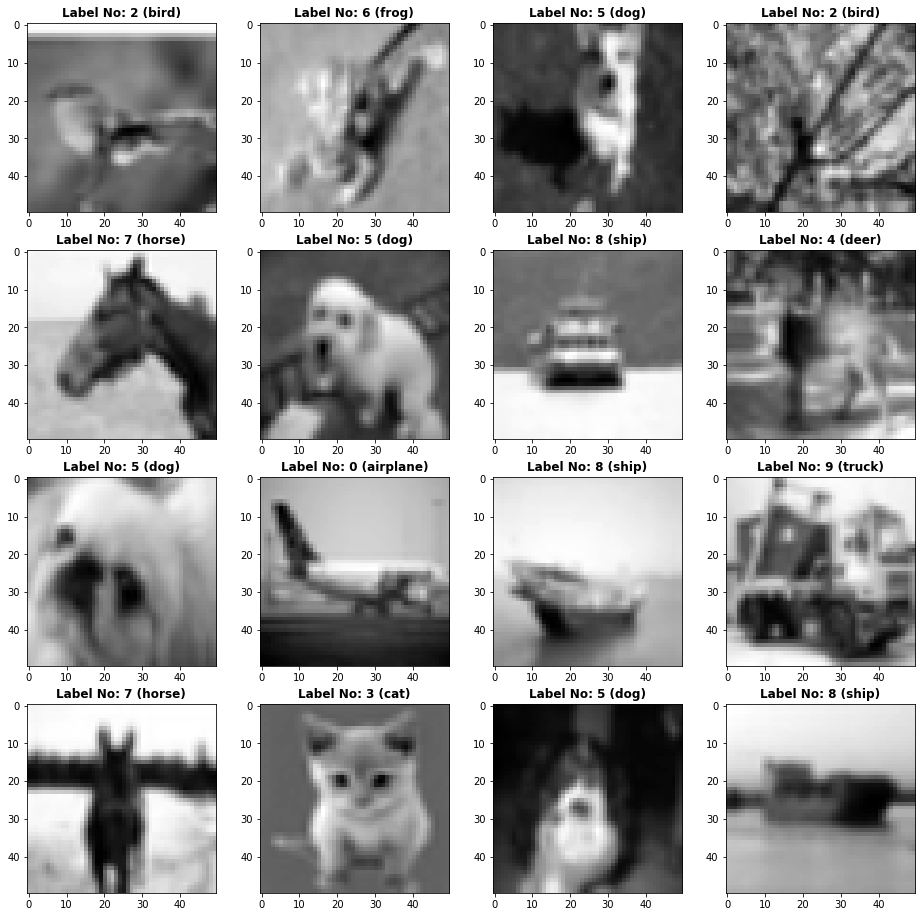

In [14]:
# some of the random choice images
plt.figure(figsize=(16,16))
subplot_num = 1
for i in np.random.randint(0,2500,16):
    plt.subplot(4,4,subplot_num)
    example = np.resize(train_df.iloc[i, :], (50,50)).astype("uint8")
    plt.imshow(example, cmap="gray")
    label = df_labels.loc[indices[i], "label"]
    label_no = train_df.loc[i, "Label #"]
    plt.title(f"Label No: {label_no} ({label})", 
              size=12, weight="bold")
    subplot_num+=1
plt.show()
del subplot_num

## 2. Dimensionality Reduction Study

In [15]:
import seaborn as sns
sns.set_style("whitegrid")

# defining independent & dependent variables, X & y
X = train_df.iloc[:, :-3]
y = train_df["Label #"]

### 2.1. Principle Component Analysis (PCA)

In [16]:
from sklearn.decomposition import PCA

In [17]:
# standardize the values
X_std = X/255.0
# StandardScaler() would create negative values
# that causes error in PCA fit_transform()

In [18]:
# we'll see the variation distribution through the eigenvalues
def eig_vals():
    X_std_T = X_std.T
    C_X = np.cov(X_std_T)
    eig_val_cov, eig_vec_cov = np.linalg.eig(C_X)

    plt.figure(dpi=100)
    plt.plot(eig_val_cov)
    plt.xlim(0,150)
    plt.ylim(0,150)
    plt.show()
# eig_vals()    # skipped.

In [19]:
# let's take 100 components on our PCA model
pca_model = PCA(n_components=50)
X_pca = pca_model.fit_transform(X_std)

print(f"With {pca_model.n_components_} components, our model explains \
{sum(pca_model.explained_variance_ratio_)*100:.1f}% of our data.")

With 50 components, our model explains 89.9% of our data.


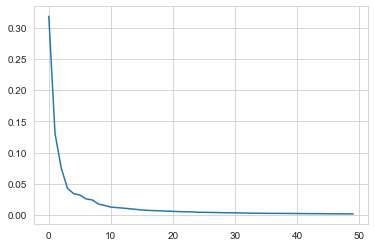

In [20]:
plt.plot(pca_model.explained_variance_ratio_)
plt.show()
# down below we see that n_components=40 
# would do the work as well with 88% of data.

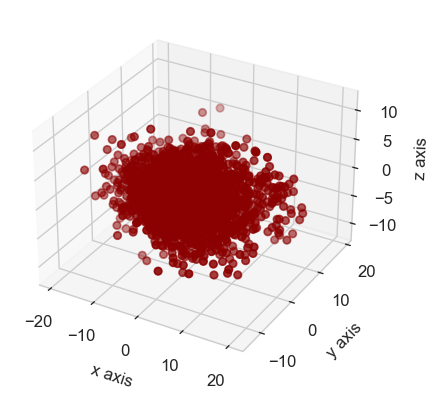

In [21]:
def plot_3D(independent_variable, interaction="passive", color="darkred"):
    """Note that, we have a bug:
    May need to run the cell a few times to view it in interactive mode."""
    if interaction == "passive":
        %matplotlib inline
    elif interaction == "active":
        %matplotlib notebook
    else:
        return "Only 'passive' & 'active' modes are valid."
    
    fig=plt.figure(dpi=120)
    ax=fig.add_subplot(111, projection="3d")

    ax.scatter(independent_variable.T[0], 
               independent_variable.T[1], 
               independent_variable.T[2], 
               color=color)
    ax.set_xlabel("x axis")
    ax.set_ylabel("y axis")
    ax.set_zlabel("z axis")
    plt.show()

plot_3D(X_pca, "passive")

### 2.2. t-distributed Stochastic Neighbor Embedding (t-SNE)

In [22]:
from sklearn.manifold import TSNE

In [23]:
# t-SNE model 1 with perplexity=5
time_start = time.time()
tsne_model1 = TSNE(n_components=3, 
                   perplexity=5, 
                   n_iter=1000, 
                   verbose=True, 
                   n_jobs=-1)
X_tsne1 = tsne_model1.fit_transform(X_std)
print(f"t-SNE is completed in {(time.time()-time_start):.1f} seconds.")

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 2500 samples in 1.650s...
[t-SNE] Computed neighbors for 2500 samples in 11.405s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2500
[t-SNE] Computed conditional probabilities for sample 2000 / 2500
[t-SNE] Computed conditional probabilities for sample 2500 / 2500
[t-SNE] Mean sigma: 1.728789
[t-SNE] KL divergence after 250 iterations with early exaggeration: 126.955208
[t-SNE] KL divergence after 1000 iterations: 2.799039
t-SNE is completed in 76.2 seconds.


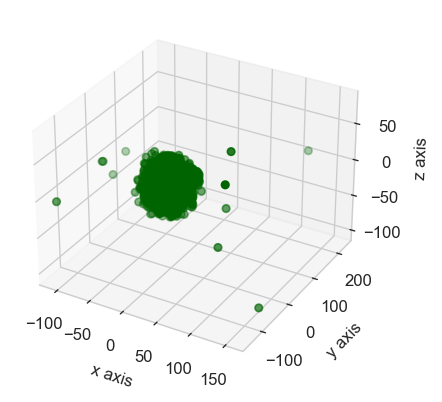

In [24]:
plot_3D(X_tsne1, "passive", "darkgreen")

In [25]:
# t-SNE model 1 with perplexity=40
time_start = time.time()
tsne_model2 = TSNE(n_components=3, 
                   perplexity=40, 
                   n_iter=1000, 
                   verbose=False, 
                   n_jobs=-1)
X_tsne2 = tsne_model2.fit_transform(X_std)
print(f"t-SNE is completed in {(time.time()-time_start):.1f} seconds.")

t-SNE is completed in 95.9 seconds.


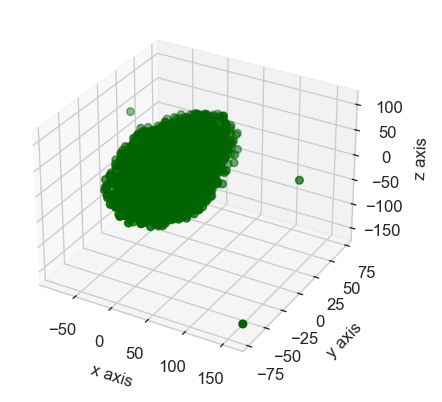

In [26]:
plot_3D(X_tsne2, "passive", "darkgreen")

### 2.3. Uniform Manifold Approximation and Projection (UMAP)

In [27]:
from umap import UMAP

In [28]:
# UMAP model 1
time_start = time.time()
umap_model1 = UMAP(n_neighbors=5,
                   min_dist=0.1,
                   metric="correlation", 
                   n_components=10, 
                   verbose=True)
X_umap1 = umap_model1.fit_transform(X_std)
print(f"UMAP modeling is completed in {(time.time()- time_start):.2f} seconds.")

UMAP(angular_rp_forest=True, metric='correlation', n_components=10,
     n_neighbors=5, verbose=True)
Construct fuzzy simplicial set
Thu Oct 22 21:40:05 2020 Finding Nearest Neighbors
Thu Oct 22 21:40:10 2020 Finished Nearest Neighbor Search
Thu Oct 22 21:40:14 2020 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Oct 22 21:40:20 2020 Finished embedding
UMAP modeling is completed in 50.53 seconds.


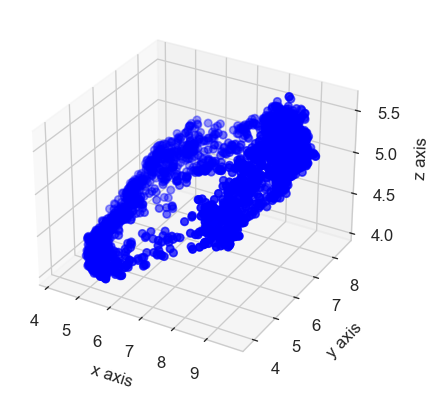

In [29]:
plot_3D(X_umap1, "passive", "blue")

In [30]:
# UMAP model 2
time_start = time.time()
umap_model2 = UMAP(n_neighbors=50,
                   min_dist=0.1,
                   metric="euclidean", 
                   n_components=10, 
                   verbose=False)
X_umap2 = umap_model2.fit_transform(X_std)
print(f"UMAP modeling is completed in {(time.time()- time_start):.2f} seconds.")

UMAP modeling is completed in 17.67 seconds.


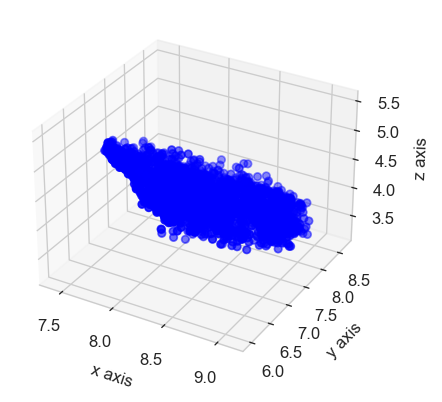

In [31]:
plot_3D(X_umap2, "passive", "blue")

# 3. Clustering Models

In [32]:
# variable list
var_list = ["X_std", "X_pca", "X_tsne1", "X_tsne2", "X_umap1", "X_umap2"]

# DataFrame for the predicted values
clusters_df = pd.DataFrame()
clusters_df["Img Name"] = train_df["Img Name"]
clusters_df["Label"] = train_df.Label
clusters_df["Label #"] = train_df["Label #"]

# DataFrame for the model scores
silhouette_df = pd.DataFrame(index=var_list)
silhouette_df.index.names = ["Variable"]
ari_df = pd.DataFrame(index=var_list)
ari_df.index.names = ["Variable"]

## 3.1. k-Means

In [33]:
from sklearn.cluster import KMeans
from sklearn import metrics

In [34]:
# list of independent variables created above:
# X_std, X_pca, X_tsne1, X_tsne2, X_umap1, X_umap2

# function for KMeans model
def kmeans_model(var):
    """The Return is a list of length three: [y_predict, z1, z2]
    y_predict: prediction of your KMeans model,
    z1: silhouette score,
    z2: adjusted Rand score of the model.
    Please use the indices 0, 1 & 2 to 
    get the returns y, z1 & z2 respectively.
    And remember: 'var' is your independent variable!"""
    kmodel = KMeans(n_clusters=10, random_state=42)
    y_predict = kmodel.fit_predict(var)
    z1 = metrics.silhouette_score(X=var, 
                                 labels=y_predict, 
                                 metric="euclidean")
    z2 = metrics.adjusted_rand_score(labels_true=y, 
                                     labels_pred=y_predict)
    return [y_predict, z1, z2]

In [35]:
%%time
def add_to_cluster_df(model_name, model):
    global var01, var02, var03, var04, var05, var06
    global var11, var12, var13, var14, var15, var16
    global var21, var22, var23, var24, var25, var26
    
    # variable for models
    var01, var02, var03, var04, var05, var06 = \
    model(X_std)[0], model(X_pca)[0], model(X_tsne1)[0], \
    model(X_tsne2)[0], model(X_umap1)[0], model(X_umap2)[0]
    # variables for silhouette scores
    var11, var12, var13, var14, var15, var16 = \
    model(X_std)[1], model(X_pca)[1], model(X_tsne1)[1], \
    model(X_tsne2)[1], model(X_umap1)[1], model(X_umap2)[1]
    # variables for Adjusted Rand scores
    var21, var22, var23, var24, var25, var26 = \
    model(X_std)[2], model(X_pca)[2], model(X_tsne1)[2], \
    model(X_tsne2)[2], model(X_umap1)[2], model(X_umap2)[2]
    
    clusters_df[f"{model_name}_std"] = var01
    clusters_df[f"{model_name}_pca"] = var02
    clusters_df[f"{model_name}_tsne1"] = var03
    clusters_df[f"{model_name}_tsne2"] = var04
    clusters_df[f"{model_name}_umap1"] = var05
    clusters_df[f"{model_name}_umap2"] = var06
add_to_cluster_df("kmeans", kmeans_model)

Wall time: 33.5 s


In [36]:
def show_silhouette(model_name):
    silhouette_df.at["X_std", f"{model_name}"] = var11
    silhouette_df.at["X_pca", f"{model_name}"] = var12
    silhouette_df.at["X_tsne1", f"{model_name}"] = var13
    silhouette_df.at["X_tsne2", f"{model_name}"] = var14
    silhouette_df.at["X_umap1", f"{model_name}"] = var15
    silhouette_df.at["X_umap2", f"{model_name}"] = var16
    print(f"Silhouette score of '{model_name}_std' model: {(var11):.3f}")
    print(f"Silhouette score of '{model_name}_pca' model: {(var12):.3f}")
    print(f"Silhouette score of '{model_name}_tsne1' model: {(var13):.3f}")
    print(f"Silhouette score of '{model_name}_tsne2' model: {(var14):.3f}")
    print(f"Silhouette score of '{model_name}_umap1' model: {(var15):.3f}")
    print(f"Silhouette score of '{model_name}_umap2' model: {(var16):.3f}")
show_silhouette("kmeans")

Silhouette score of 'kmeans_std' model: 0.057
Silhouette score of 'kmeans_pca' model: 0.065
Silhouette score of 'kmeans_tsne1' model: 0.271
Silhouette score of 'kmeans_tsne2' model: 0.259
Silhouette score of 'kmeans_umap1' model: 0.327
Silhouette score of 'kmeans_umap2' model: 0.320


In [37]:
def show_ari(model_name):
    ari_df.at["X_std", f"{model_name}"] = var21
    ari_df.at["X_pca", f"{model_name}"] = var22
    ari_df.at["X_tsne1", f"{model_name}"] = var23
    ari_df.at["X_tsne2", f"{model_name}"] = var24
    ari_df.at["X_umap1", f"{model_name}"] = var25
    ari_df.at["X_umap2", f"{model_name}"] = var26
    print(f"Adjusted Rand score of '{model_name}_std' model: {(var21):.4f}")
    print(f"Adjusted Rand score of '{model_name}_pca' model: {(var22):.4f}")
    print(f"Adjusted Rand score of '{model_name}_tsne1' model: {(var23):.4f}")
    print(f"Adjusted Rand score of '{model_name}_tsne2' model: {(var24):.4f}")
    print(f"Adjusted Rand score of '{model_name}_umap1' model: {(var25):.4f}")
    print(f"Adjusted Rand score of '{model_name}_umap2' model: {(var26):.4f}")
    
show_ari("kmeans")

Adjusted Rand score of 'kmeans_std' model: 0.0289
Adjusted Rand score of 'kmeans_pca' model: 0.0302
Adjusted Rand score of 'kmeans_tsne1' model: 0.0249
Adjusted Rand score of 'kmeans_tsne2' model: 0.0270
Adjusted Rand score of 'kmeans_umap1' model: 0.0324
Adjusted Rand score of 'kmeans_umap2' model: 0.0311


## 3.2. Hierarchical (Agglomerative) Clustering

In [38]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

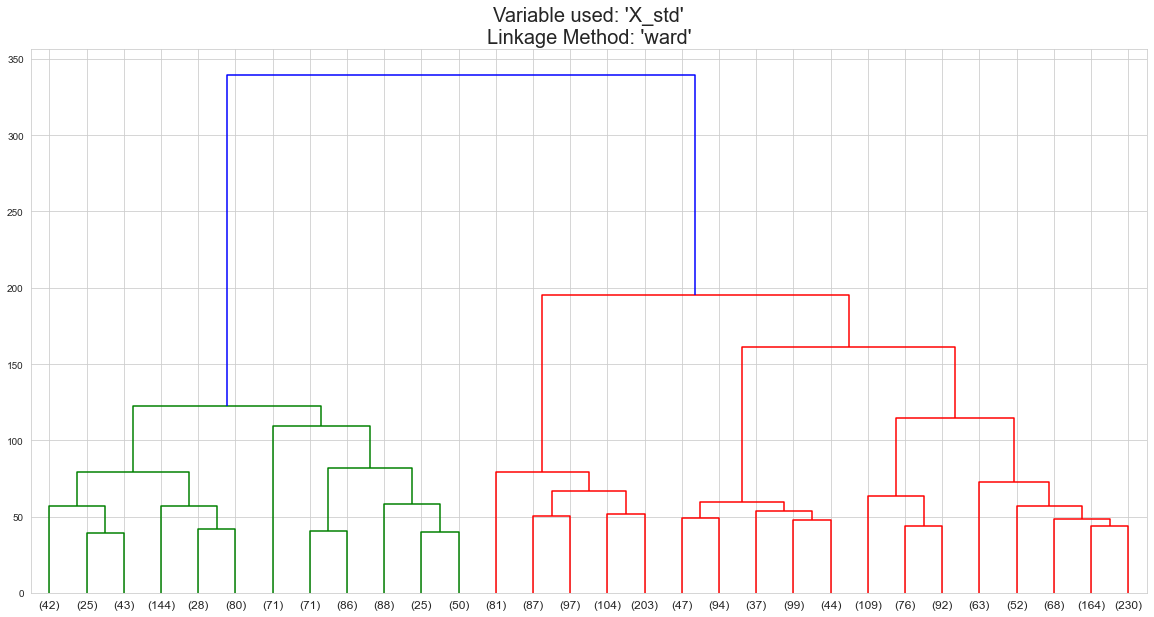

In [39]:
# dendrogram example with X_std variable
plt.figure(figsize=(20,10))
plt.title("Variable used: 'X_std'\nLinkage Method: 'ward'", size=20)
Z = linkage(X_std, 
            method="ward", 
            metric="euclidean")
dendrogram(Z=Z, 
           truncate_mode="lastp", 
           leaf_font_size=12, 
           leaf_rotation=0)
plt.show()

In [40]:
# list of independent variables created above:
# X_std, X_pca, X_tsne1, X_tsne2, X_umap1, X_umap2

# function for AgglomerativeClustering model
def aggClus_model(var):
    """The Return is a list of length three: [y_predict, z1, z2]
    y_predict: prediction of your AgglomerativeClustering model,
    z1: silhouette score,
    z2: adjusted Rand score of the model.
    Please use the indices 0, 1 & 2 to 
    get the returns y, z1 & z2 respectively.
    And remember: 'var' is your independent variable!"""
    aggClus_model = AgglomerativeClustering(n_clusters=10,
                                            affinity="euclidean",
                                            linkage="ward")
    y_predict = aggClus_model.fit_predict(var)
    z1 = metrics.silhouette_score(X=var, 
                                 labels=y_predict, 
                                 metric="euclidean")
    z2 = metrics.adjusted_rand_score(labels_true=y, 
                                     labels_pred=y_predict)
    return [y_predict, z1, z2]

In [41]:
%%time
add_to_cluster_df("aggClus", aggClus_model)

Wall time: 33.8 s


In [42]:
show_silhouette("aggClus")

Silhouette score of 'aggClus_std' model: 0.027
Silhouette score of 'aggClus_pca' model: 0.051
Silhouette score of 'aggClus_tsne1' model: 0.209
Silhouette score of 'aggClus_tsne2' model: 0.192
Silhouette score of 'aggClus_umap1' model: 0.304
Silhouette score of 'aggClus_umap2' model: 0.282


In [43]:
show_ari("aggClus")

Adjusted Rand score of 'aggClus_std' model: 0.0220
Adjusted Rand score of 'aggClus_pca' model: 0.0201
Adjusted Rand score of 'aggClus_tsne1' model: 0.0229
Adjusted Rand score of 'aggClus_tsne2' model: 0.0297
Adjusted Rand score of 'aggClus_umap1' model: 0.0290
Adjusted Rand score of 'aggClus_umap2' model: 0.0288


## 3.3. Density-based Spatial Clustering of Applications with Noise (DBSCAN)

In [44]:
from sklearn.cluster import DBSCAN

In [45]:
def dbscan_model(var):
    """The Return is a list of length three: [y_predict, z1, z2]
    y_predict: prediction of your DBSCAN model,
    z1: silhouette score,
    z2: adjusted Rand score of the model.
    Please use the indices 0, 1 & 2 to get the returns y, z1 & z2 respectively.
    Note that there may not be always a Silhouette score for the model!
    And remember: 'var' is your independent variable!"""
    dbscan_model = DBSCAN(eps=8, 
                          min_samples=4, 
                          metric="euclidean", 
                          leaf_size=30, 
                          n_jobs=-1)
    y_predict = dbscan_model.fit_predict(var)
    try:
        z1 = metrics.silhouette_score(X=var, 
                                     labels=y_predict, 
                                     metric="euclidean")
    except ValueError:
        z1 = np.nan
    z2 = metrics.adjusted_rand_score(labels_true=y, 
                                     labels_pred=y_predict)
    return [y_predict, z1, z2]

In [46]:
%%time
add_to_cluster_df("dbscan", dbscan_model)

Wall time: 1min 48s


In [47]:
# prediction models and their cluster numbers
for i in clusters_df.columns[-6:]:
    predict_count = len(np.unique(clusters_df[i], return_counts=True)[0])
    print(f"Number of predicted clusters for '{i}' model:", predict_count)

Number of predicted clusters for 'dbscan_std' model: 3
Number of predicted clusters for 'dbscan_pca' model: 2
Number of predicted clusters for 'dbscan_tsne1' model: 2
Number of predicted clusters for 'dbscan_tsne2' model: 35
Number of predicted clusters for 'dbscan_umap1' model: 1
Number of predicted clusters for 'dbscan_umap2' model: 1


In [48]:
show_silhouette("dbscan")

Silhouette score of 'dbscan_std' model: 0.011
Silhouette score of 'dbscan_pca' model: 0.118
Silhouette score of 'dbscan_tsne1' model: 0.396
Silhouette score of 'dbscan_tsne2' model: -0.499
Silhouette score of 'dbscan_umap1' model: nan
Silhouette score of 'dbscan_umap2' model: nan


In [49]:
show_ari("dbscan")

Adjusted Rand score of 'dbscan_std' model: 0.0275
Adjusted Rand score of 'dbscan_pca' model: 0.0069
Adjusted Rand score of 'dbscan_tsne1' model: 0.0000
Adjusted Rand score of 'dbscan_tsne2' model: 0.0017
Adjusted Rand score of 'dbscan_umap1' model: 0.0000
Adjusted Rand score of 'dbscan_umap2' model: 0.0000


## 3.4. Gaussian Mixture Model (GMM)

In [50]:
from sklearn.mixture import GaussianMixture

In [51]:
# list of independent variables created above:
# X_std, X_pca, X_tsne1, X_tsne2, X_umap1, X_umap2

def gmm_model(var, cov="diag"):
    """The Return is a list of length four: [y_predict, z0, z1, z2]
    y_predict: prediction of your GaussianMixture model,
    z1: silhouette score,
    z2: adjusted Rand score of the model.
    z3: Bayesian Information Criterion score
    Please use indices to get the returns.
    And remember: 
    'var' is your independent variable,
    'cov' is the covariance type."""
    gauss_model = GaussianMixture(n_components=10, 
                                  covariance_type=cov, 
                                  max_iter=500, 
                                  reg_covar=0.03)
    y_predict = gauss_model.fit_predict(var)
    z1 = metrics.silhouette_score(X=var,
                                  labels=y_predict,
                                  metric="euclidean")
    z2 = metrics.adjusted_rand_score(labels_true=y, 
                                     labels_pred=y_predict)
    z3 = gauss_model.bic(var)
    
    return [y_predict, z1, z2, z3]

In [52]:
# why don't we get the BIC scores first?
# let's take X_pca variable for example
covariance_list = ["full", "tied", "diag", "spherical"]

for cov in covariance_list:
    print("BIC score of covariance type '{0}' is: {1:.1f}"\
          .format(cov, gmm_model(X_pca, cov)[3]))

BIC score of covariance type 'full' is: 400874.4
BIC score of covariance type 'tied' is: 343187.3
BIC score of covariance type 'diag' is: 323993.3
BIC score of covariance type 'spherical' is: 399918.6


Since the minimum _Bayesian Information Criterion_ is observed on the covariance type **"diag"** _(where each component has its own diagonal covariance matrix)_, we update the function's **cov** variable to a default value, "diag".

In [53]:
%%time
add_to_cluster_df("gmm", gmm_model)

Wall time: 27.1 s


In [54]:
show_silhouette("gmm")

Silhouette score of 'gmm_std' model: 0.077
Silhouette score of 'gmm_pca' model: -0.029
Silhouette score of 'gmm_tsne1' model: 0.230
Silhouette score of 'gmm_tsne2' model: 0.244
Silhouette score of 'gmm_umap1' model: 0.301
Silhouette score of 'gmm_umap2' model: 0.281


In [55]:
show_ari("gmm")

Adjusted Rand score of 'gmm_std' model: 0.0215
Adjusted Rand score of 'gmm_pca' model: 0.0330
Adjusted Rand score of 'gmm_tsne1' model: 0.0233
Adjusted Rand score of 'gmm_tsne2' model: 0.0269
Adjusted Rand score of 'gmm_umap1' model: 0.0333
Adjusted Rand score of 'gmm_umap2' model: 0.0258


In [56]:
# we thank the variables and send them home
del var01, var02, var03, var04, var05, var06,\
var11, var12, var13, var14, var15, var16,\
var21, var22, var23, var24, var25, var26

# 4. Results

First, we're going to gather the scores in one data frame. Thus an additional indices will be needed to distinguish the scores as **"Adjusted Rand"** & **"Silhouette"** scores. 

In [57]:
# list of independent variables created above:
# X_std, X_pca, X_tsne1, X_tsne2, X_umap1, X_umap2

index_list = ari_df.index

In [58]:
# our second index
multi_index_list = ["Adjusted Rand", "Silhouette"]

In [59]:
# now it's time to merge the indices.
# we will have an index column "Scores",
# and another one "Variables".
multi_index_mask = pd.MultiIndex.from_product([multi_index_list, index_list], 
                                              names=['Scores','Variables'])

In [60]:
# let's summon the 'scores_df' to rule them all!
scores_df = pd.DataFrame(pd.concat([ari_df, silhouette_df], axis=0))

## above in the pd.Dataframe() line, 'index=multi_index_mask' didn't work :/
## "ValueError: cannot reindex from a duplicate axis"

In [61]:
# time to change the indices!
scores_df.index = multi_index_mask
# and get rid of now-useless variables
del multi_index_list, multi_index_mask    

In [62]:
# you can get the sub-dataframes with this code:
pd.options.display.float_format = '{:.4f}'.format
scores_df

kmeans  aggClus  dbscan     gmm
Scores        Variables                                 
Adjusted Rand X_std      0.0289   0.0220  0.0275  0.0215
              X_pca      0.0302   0.0201  0.0069  0.0330
              X_tsne1    0.0249   0.0229  0.0000  0.0233
              X_tsne2    0.0270   0.0297  0.0017  0.0269
              X_umap1    0.0324   0.0290  0.0000  0.0333
              X_umap2    0.0311   0.0288  0.0000  0.0258
Silhouette    X_std      0.0572   0.0265  0.0112  0.0774
              X_pca      0.0648   0.0512  0.1179 -0.0295
              X_tsne1    0.2715   0.2091  0.3955  0.2303
              X_tsne2    0.2593   0.1921 -0.4990  0.2444
              X_umap1    0.3268   0.3043     nan  0.3010
              X_umap2    0.3203   0.2818     nan  0.2809

When we check the Adjusted Rand Indices,

In [63]:
display(scores_df.xs("Adjusted Rand"))
print("Mean values of the Adjusted Rand scores:\n", 
      scores_df.xs("Adjusted Rand").mean(), 
      sep="")

,kmeans,aggClus,dbscan,gmm
Variables,,,,
X_std,0.0289,0.0220,0.0275,0.0215
X_pca,0.0302,0.0201,0.0069,0.0330
X_tsne1,0.0249,0.0229,0.0000,0.0233
X_tsne2,0.0270,0.0297,0.0017,0.0269
X_umap1,0.0324,0.0290,0.0000,0.0333
X_umap2,0.0311,0.0288,0.0000,0.0258


Mean values of the Adjusted Rand scores:
kmeans    0.0291
aggClus   0.0254
dbscan    0.0060
gmm       0.0273
dtype: float64


we see that **k-means** has slightly higher scores than  **Gaussian Mixture** and **Hierarchical Clustering** models. However, including dimension reduction techniques, UMAP particularly, the best scores seem to be the ones in both k-means and GM models. To reach a verdict, let's examine the heatmaps below.

In [64]:
clusters_df.head(3)

,Img Name,Label,Label #,kmeans_std,kmeans_pca,kmeans_tsne1,kmeans_tsne2,kmeans_umap1,kmeans_umap2,aggClus_std,...,dbscan_tsne1,dbscan_tsne2,dbscan_umap1,dbscan_umap2,gmm_std,gmm_pca,gmm_tsne1,gmm_tsne2,gmm_umap1,gmm_umap2
0,49502.png,ship,8,6,0,9,7,5,4,2,...,0,0,0,0,9,4,1,5,7,8
1,20556.png,airplane,0,2,9,6,4,9,2,6,...,0,0,0,0,8,9,6,3,3,5
2,6112.png,truck,9,6,0,2,1,0,3,1,...,0,-1,0,0,3,0,4,0,6,0


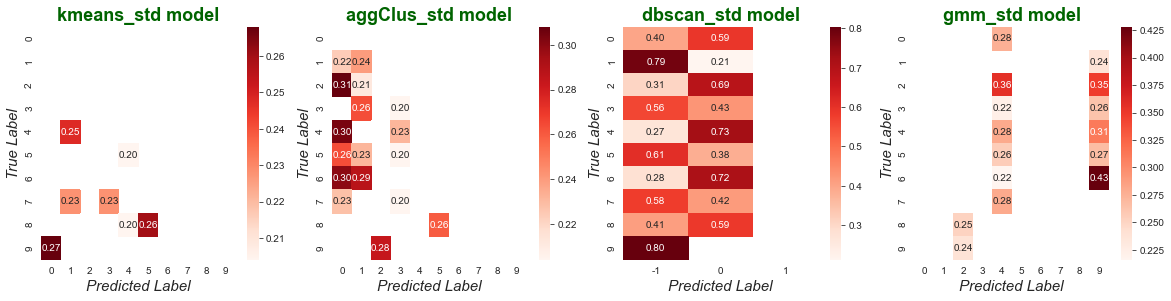

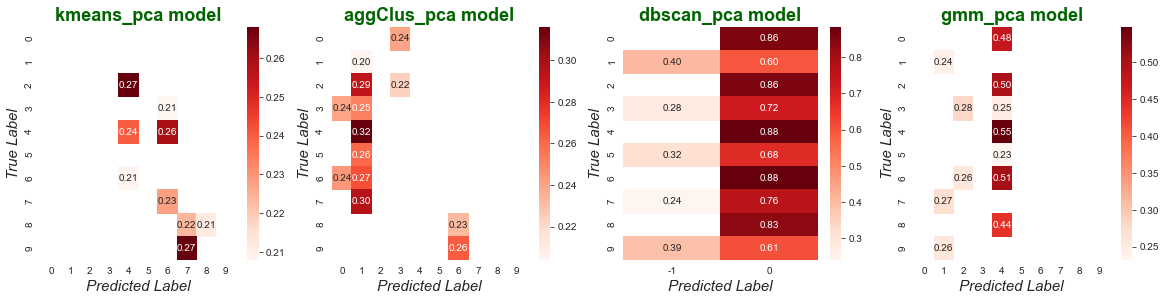

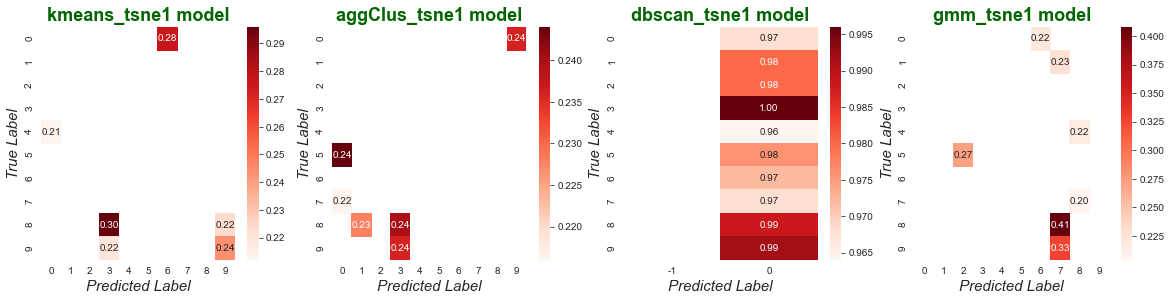

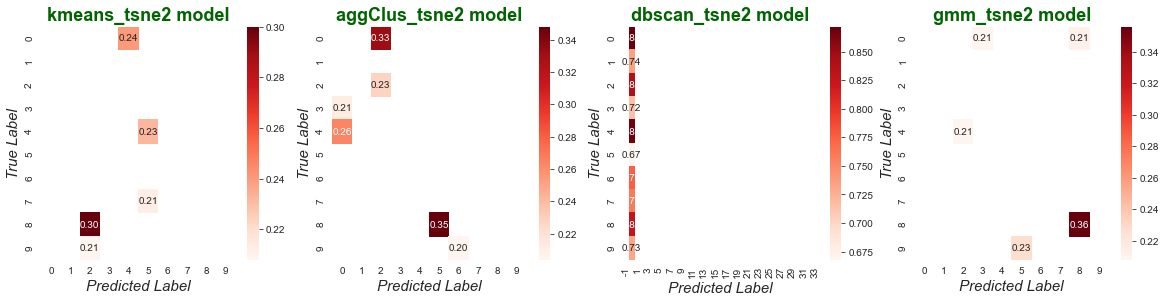

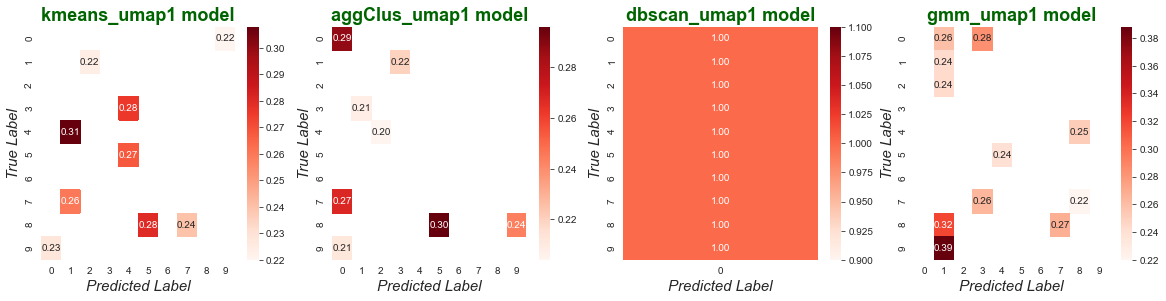

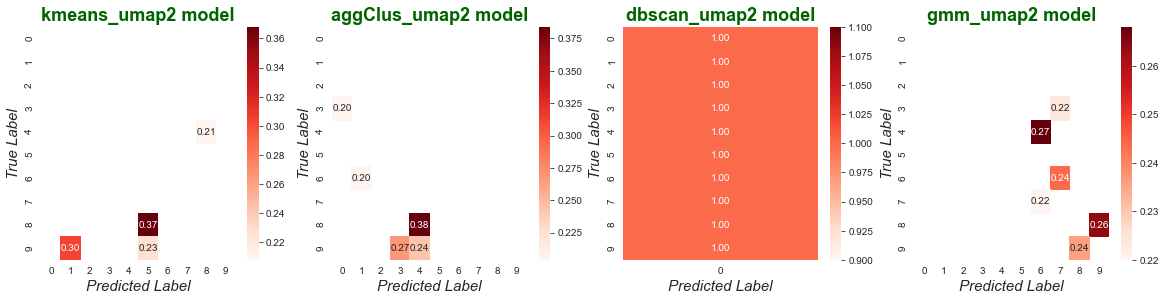

In [65]:
%matplotlib inline
counter = 1
for i in range(len(index_list)):
    plt.figure(figsize=(20,30))
    for model in scores_df.columns:
        plt.subplot(6,4,counter)
        column_name = model + index_list[i][1:]    # to create e.g 'kmeans_tsne1'
        cross_tab = pd.crosstab(clusters_df["Label #"], clusters_df[column_name])/250
        sns.heatmap(cross_tab[cross_tab>0.2], 
                    annot=True, 
                    cmap="Reds", fmt=".2f")
        plt.title(column_name+" model", size=18, color="darkgreen", weight="bold")
        plt.xlabel("Predicted Label", size=15, style="italic")
        plt.ylabel("True Label", size=15, style="italic")
        counter += 1
    plt.show()
del counter

Even though there is no distinct victory among two, **Gaussian Mixture Model** with the dimension reduction technique **UMAP** (with the 1st choice parameters) have an edge over k-means. Let's choose the model and show some random images.

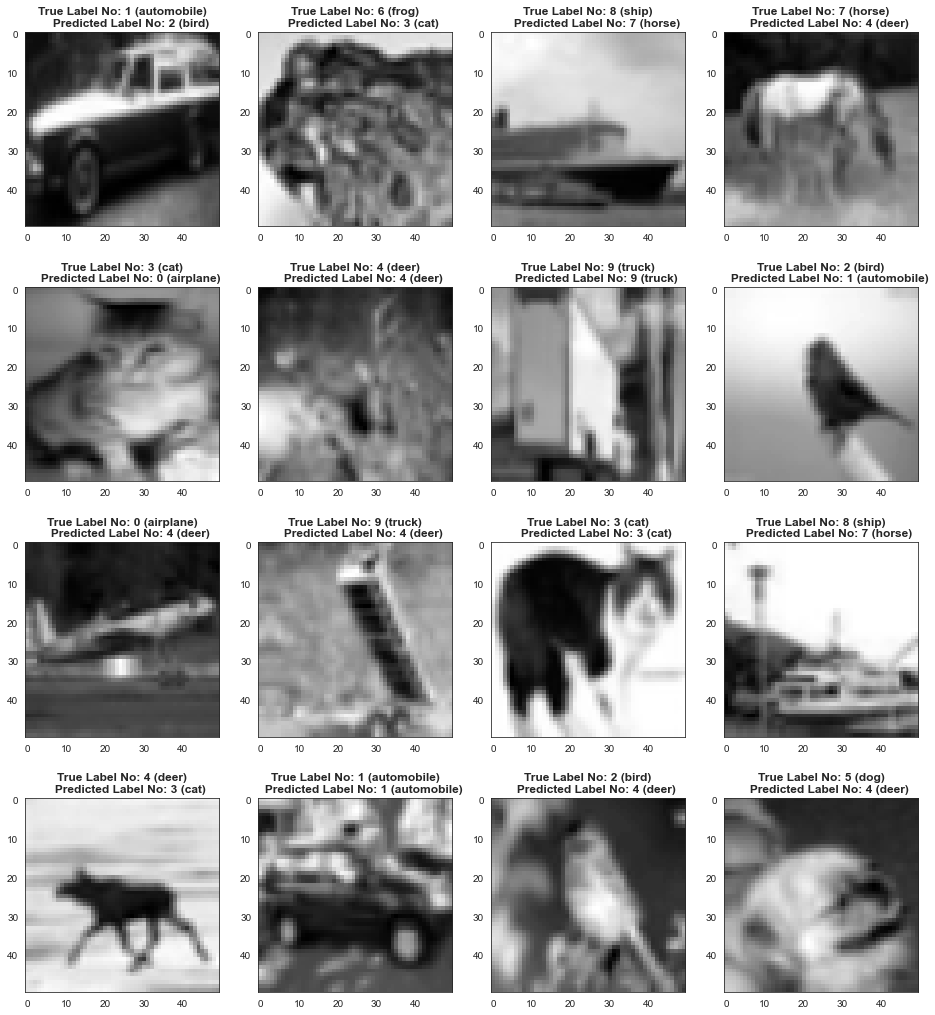

In [66]:
# 16 random choice images
plt.figure(figsize=(16,18))
sns.set_style("white")
subplot_num = 1
for i in np.random.randint(0,2500,16):
    plt.subplot(4,4,subplot_num)
    example = np.resize(train_df.iloc[i, :], (50,50)).astype("uint8")
    plt.imshow(example, cmap="gray")
    
    t_label = df_labels.loc[indices[i], "label"]    # true label
    t_label_no = train_df.loc[i, "Label #"]
    p_label_no = clusters_df.loc[i, "gmm_umap1"]    # predicted label
    p_label = dict(labels_ordered)[p_label_no]
    
    plt.title(f"True Label No: {t_label_no} ({t_label})\n \
    Predicted Label No: {p_label_no} ({p_label})", 
              size=12, weight="bold")
    subplot_num+=1
plt.show()
del subplot_num

Note that accuracy scores and the matches shown above is quite bad.